In [188]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,TensorDataset
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm import tqdm
import torch.optim as optim

In [189]:
DATASET_PATH = "cifar10_images"
transform = transforms.Compose([transforms.Resize((96,96)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = ImageFolder(root="/home/rajdeep/UMC203project/cifar10_images/train", transform=transform)
test_dataset = ImageFolder(root="/home/rajdeep/UMC203project/cifar10_images/test", transform=transform)

In [190]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

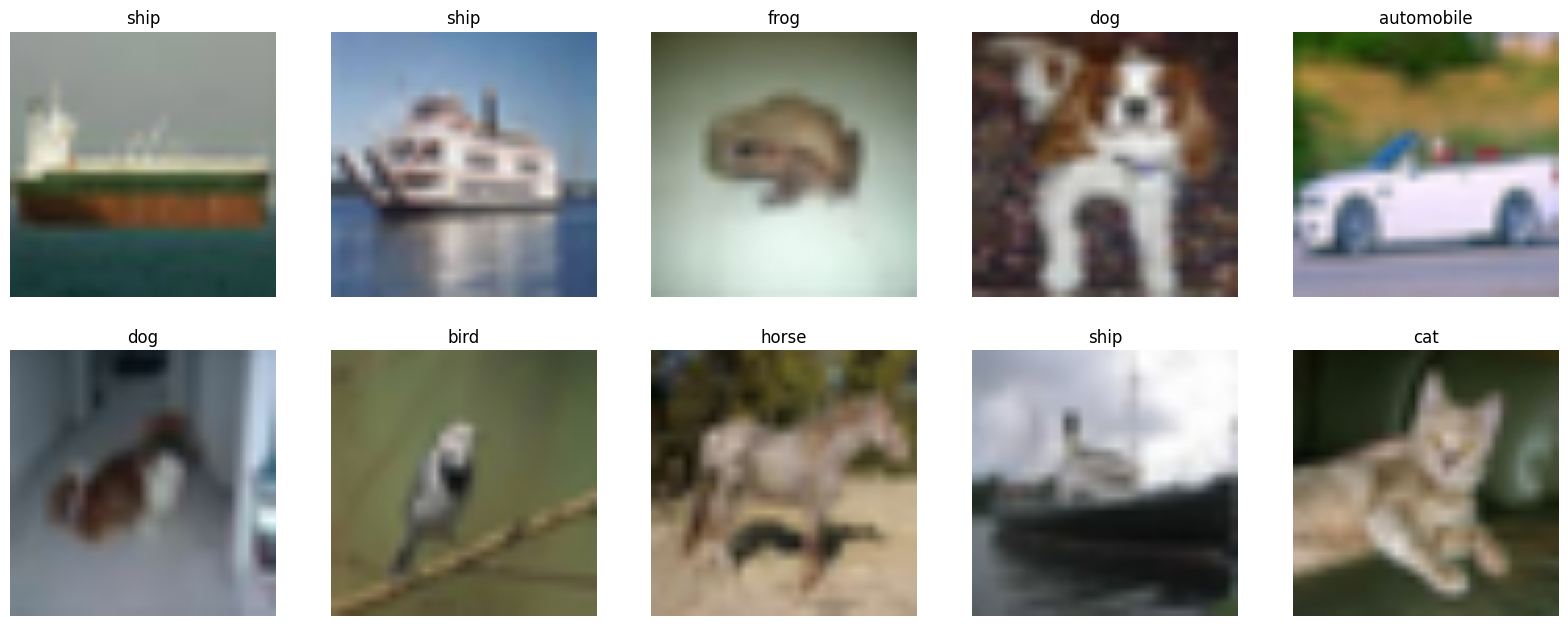

In [191]:
plt.figure(figsize=(20, 20))
for i in range(10):
    image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0)/2 + 0.5)
    plt.title(train_dataset.classes[label])
    plt.axis("off")

In [192]:
class Patch_Linear_Embedding(nn.Module):
    def __init__(self, patch_size=4, embedding_dim=96):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.proj = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        

    def forward(self, x):
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5) 
        x = x.reshape(x.shape[0] ,x.shape[1],x.shape[2] , self.patch_size * self.patch_size * 3)
        x = self.proj(x)
        return x     

In [193]:
class W_MSA(nn.Module):
    def __init__(self, dim, window_size=6, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)
    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)


        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        attn = torch.softmax(scores, dim=-1)

        # Weighted sum of values
        out = torch.matmul(attn, v)  # [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)  # [total, ws * ws, dim]

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)  # [B, H//ws, W//ws, ws, ws, D]
        out = out.permute(0, 1, 3, 2, 4, 5)  # [B, H//ws, W//ws, D, ws, ws]
        out = out.reshape(B, H, W, D)  # [B, H, W, D] - Reconstructed
        return out


In [194]:
def mask(B, H, W,ss,ws):
    mask = torch.zeros(B, H, W, dtype=torch.int)
    mask[:, :ss, :ss] = 0
    mask[:, :ss, ss:] = 1
    mask[:, ss:, :ss] = 2
    mask[:, ss:, ss:] = 3
    shift_size = ss
    shifted_mask = torch.roll(mask, shifts=(-shift_size, -shift_size), dims=(1, 2))
    shifted_mask = shifted_mask.reshape(B, H // ws, ws, W // ws, ws)
    shifted_mask = shifted_mask.permute(0, 1, 3, 2, 4)
    shifted_mask = shifted_mask.reshape(-1, ws * ws)
    N, L = shifted_mask.shape  
    eq = shifted_mask.unsqueeze(2) == shifted_mask.unsqueeze(1)  
    attn_mask = torch.where(eq, torch.tensor(0.0), torch.tensor(float('-inf')))
    return attn_mask

In [195]:
class SW_MSA(nn.Module):
    def __init__(self, dim, window_size=6, shift_size=3, num_heads=8):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** 0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: (B, H, W, D)
        """
        B, H, W, D = x.shape
        ws = self.window_size
        ss = self.shift_size
        x = torch.roll(x, shifts=(-ss, -ss), dims=(1, 2))


        attn_mask = mask(B, H, W, ss, ws)
        


        x = x.reshape(B, H // ws, ws, W // ws, ws, D)
        x = x.permute(0, 1, 3, 2, 4, 5)
        x = x.reshape(-1, ws * ws, D)

        M, V, C = x.shape  # [total, ws * ws, dim]
        qkv = self.qkv(x)  # [total, ws * ws, 3 * dim]
        qkv = qkv.reshape(M, V, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, total, heads, ws * ws, head_dim]

        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [total, heads, ws * ws, head_dim]

        # Attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [total, heads, ws * ws, ws * ws]
        scores = scores + attn_mask.unsqueeze(1)
        attn = torch.softmax(scores, dim=-1)
        # Weighted sum of values
        out = torch.matmul(attn, v)# [total, heads, ws * ws, head_dim]
        out = out.permute(0, 2, 1, 3).reshape(M, V, C)

        # Reverse the window partitioning
        out = out.reshape(B, H // ws, W // ws, ws, ws, D)
        out = out.permute(0, 1, 3, 2, 4, 5)
        out = out.reshape(B, H, W, D)
        out = torch.roll(out, shifts=(ss, ss), dims=(1, 2))
        out = self.proj(out)
        return out

In [196]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads = 8, window_size=6, shift_size=3):
        super().__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.attn1 = W_MSA(dim, num_heads=num_heads, window_size=window_size)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp1 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.attn2 = SW_MSA(dim, num_heads=num_heads, window_size=window_size, shift_size=shift_size)
        
        
        self.mlp2 = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        


    def forward(self, x):
        B, H, W, C = x.shape

        x = x + self.attn1(self.norm1(x))
        x = x + self.mlp1(self.norm2(x))
        x = x + self.attn2(self.norm1(x))
        x = x + self.mlp2(self.norm2(x))
        return x

In [175]:
class PatchMerging(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.reduction = nn.Linear(4 * input_dim, 2 * input_dim, bias=False)
        self.norm = nn.LayerNorm(4 * input_dim)

    def forward(self, x):
        B, H, W, C = x.shape

        # Step 1: reshape 2x2 patches into one
        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 0::2, 1::2, :]  # top-right
        x2 = x[:, 1::2, 0::2, :]  # bottom-left
        x3 = x[:, 1::2, 1::2, :]  # bottom-right
        # Step 2: concatenate along the channel dimension
        x_merged = torch.cat([x0, x1, x2, x3], dim=-1)  # Shape: [B, H/2, W/2, 4C]
        # Step 3: normalization and linear projection to reduce dim
        x_merged = self.norm(x_merged)
        x_merged = self.reduction(x_merged)  # Shape: [B, H/2, W/2, 2C]
        return x_merged
    


In [197]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=384, num_classes=10):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # pools HxW to 1x1
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: [B, H, W, C] → convert to [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        x = self.avg_pool(x)           # [B, C, 1, 1]
        x = x.reshape(x.size(0), -1)      # [B, Cx1x1]
        return self.fc(x)              # [B, num_classes]
    

In [198]:
class SimpleSwinTransformer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.embedding = Patch_Linear_Embedding(patch_size=4, embedding_dim=96)
        self.stb1 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb2 = SwinTransformerBlock(dim=96, window_size=6, shift_size=3, num_heads=8)
        self.stb3 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb4 = SwinTransformerBlock(dim=192, window_size=6, shift_size=3, num_heads=8)
        self.stb5 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.stb6 = W_MSA(dim = 384, window_size=6, num_heads=8)
        self.patch_merging1 = PatchMerging(input_dim=96)
        self.patch_merging2 = PatchMerging(input_dim=192)
        self.classification_head = ClassificationHead(embed_dim=384, num_classes=num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.stb1(x)
        x = self.stb2(x)
        x = self.patch_merging1(x)
        x = self.stb3(x)
        x = self.stb4(x)
        x = self.patch_merging2(x)
        x = self.stb5(x)
        x = self.stb6(x)
        x = self.classification_head(x)
        return x
    


In [199]:
# Instantiate everything
device = torch.device("cpu")
model = SimpleSwinTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [200]:
# Training loop
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device)
        

        outputs = model(imgs)     # [B, 10]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Train Loss: {avg_loss:.4f}")

In [201]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            

            outputs = model(imgs)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

In [202]:
# Train for a few epochs
for epoch in range(1, 6):
    train(model, train_loader, optimizer, criterion, epoch)
    evaluate(model, test_loader)
     # Save model after each epoch (optional)
    torch.save(model.state_dict(), f"simple_swin_epoch{epoch}.pth")

Epoch 1:   5%|▍         | 38/782 [01:30<29:41,  2.39s/it]


KeyboardInterrupt: 